In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import joblib
import warnings
warnings.filterwarnings('ignore')
sns.set_style("whitegrid")

In [2]:
df = pd.read_csv(r"D:\6-Data Sets\Supermarket_sales.csv")
print(df.head())
print(df.info())
print(df.describe())

    Invoice ID Branch       City Customer type  Gender  \
0  750-67-8428      A     Yangon        Member  Female   
1  226-31-3081      C  Naypyitaw        Normal  Female   
2  631-41-3108      A     Yangon        Normal    Male   
3  123-19-1176      A     Yangon        Member    Male   
4  373-73-7910      A     Yangon        Normal    Male   

             Product line  Unit price  Quantity   Tax 5%     Total       Date  \
0       Health and beauty       74.69         7  26.1415  548.9715   1/5/2019   
1  Electronic accessories       15.28         5   3.8200   80.2200   3/8/2019   
2      Home and lifestyle       46.33         7  16.2155  340.5255   3/3/2019   
3       Health and beauty       58.22         8  23.2880  489.0480  1/27/2019   
4       Sports and travel       86.31         7  30.2085  634.3785   2/8/2019   

    Time      Payment    cogs  gross margin percentage  gross income  Rating  
0  13:08      Ewallet  522.83                 4.761905       26.1415     9.1  
1  10:

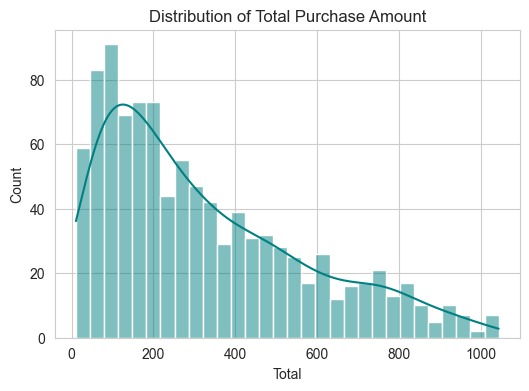

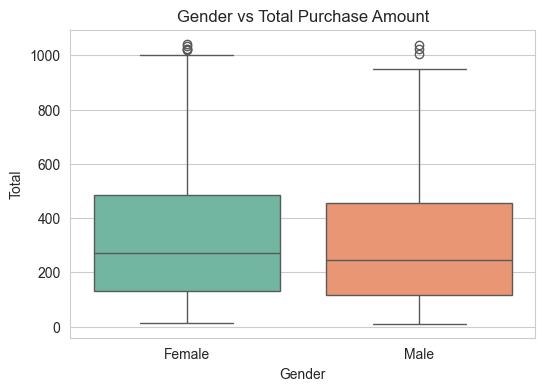

In [3]:
plt.figure(figsize=(6,4))
sns.histplot(df['Total'], bins=30, kde=True, color='teal')
plt.title("Distribution of Total Purchase Amount")
plt.show()

plt.figure(figsize=(6,4))
sns.boxplot(x='Gender', y='Total', data=df, palette='Set2')
plt.title("Gender vs Total Purchase Amount")
plt.show()

In [4]:
# Encode categorical columns
le_customer = LabelEncoder()
le_payment = LabelEncoder()
df['Customer type'] = le_customer.fit_transform(df['Customer type'])  # Member=1, Normal=0
df['Payment'] = le_payment.fit_transform(df['Payment'])  # Cash, Ewallet, Credit card
df['Gender'] = le_customer.fit_transform(df['Gender'])  # Male=1, Female=0


In [6]:
# Select features for clustering
features = ['Customer type', 'Gender', 'Unit price', 'Quantity', 'Total', 'Payment', 'Rating']
X = df[features]

# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


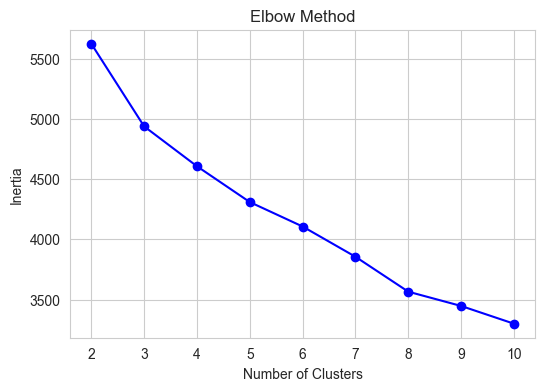

In [7]:
inertia = []
K_range = range(2,11)
for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_scaled)
    inertia.append(kmeans.inertia_)

plt.figure(figsize=(6,4))
plt.plot(K_range, inertia, 'bo-')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.title('Elbow Method')
plt.show()

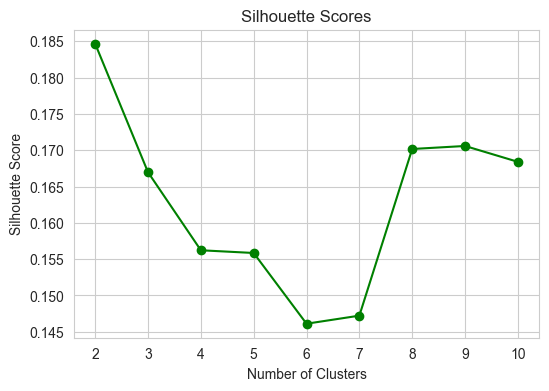

In [8]:
# Silhouette scores
sil_scores = []
for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(X_scaled)
    sil_scores.append(silhouette_score(X_scaled, labels))

plt.figure(figsize=(6,4))
plt.plot(K_range, sil_scores, 'go-')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Scores')
plt.show()

In [9]:
# Assuming optimal clusters = 4
kmeans = KMeans(n_clusters=4, random_state=42)
clusters = kmeans.fit_predict(X_scaled)
df['Cluster'] = clusters

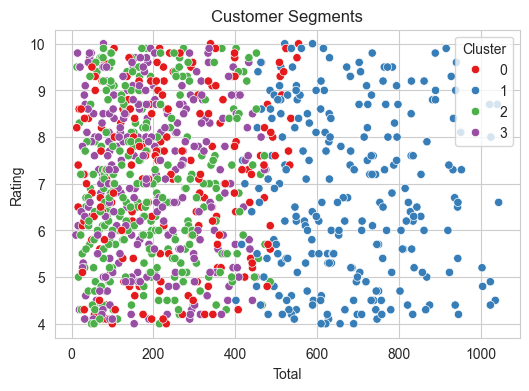

In [10]:
# Visualize clusters (Total vs Rating)
plt.figure(figsize=(6,4))
sns.scatterplot(x='Total', y='Rating', hue='Cluster', data=df, palette='Set1')
plt.title("Customer Segments")
plt.show()


In [11]:
# Save model and scaler
joblib.dump(kmeans, 'kmeans_supermarket.pkl')
joblib.dump(scaler, 'scaler_supermarket.pkl')
print("Clustering model and scaler saved successfully!")


Clustering model and scaler saved successfully!


In [13]:
import streamlit as st
import pandas as pd
import joblib
import seaborn as sns
import matplotlib.pyplot as plt

# Load model and scaler
kmeans = joblib.load('kmeans_supermarket.pkl')
scaler = joblib.load('scaler_supermarket.pkl')

st.set_page_config(page_title="Supermarket Customer Segmentation", layout="centered")
st.title("🛒 Supermarket Customer Segmentation")

st.sidebar.header("Customer Details")
Customer_type = st.sidebar.selectbox("Customer Type", ["Normal", "Member"])
Gender = st.sidebar.selectbox("Gender", ["Female", "Male"])
Unit_price = st.sidebar.number_input("Unit Price ($)", min_value=0.0, max_value=500.0, value=50.0)
Quantity = st.sidebar.slider("Quantity", 1, 10, 2)
Total = st.sidebar.number_input("Total ($)", min_value=0.0, max_value=5000.0, value=200.0)
Payment = st.sidebar.selectbox("Payment Method", ["Cash", "Ewallet", "Credit card"])
Rating = st.sidebar.slider("Rating (1-10)", 1.0, 10.0, 7.0)

# Encode categorical values
customer_type = 1 if Customer_type=="Member" else 0
gender = 1 if Gender=="Male" else 0
payment_dict = {"Cash":0, "Ewallet":1, "Credit card":2}
payment = payment_dict[Payment]

# Create dataframe
data = pd.DataFrame({
    'Customer type':[customer_type],
    'Gender':[gender],
    'Unit price':[Unit_price],
    'Quantity':[Quantity],
    'Total':[Total],
    'Payment':[payment],
    'Rating':[Rating]
})

# Scale
data_scaled = scaler.transform(data)

# Predict cluster
if st.button("Find Customer Segment"):
    cluster = kmeans.predict(data_scaled)[0]
    st.success(f"Customer belongs to **Segment {cluster}**")

    # Optional visualization
    df = pd.read_csv(r"D:\6-Data Sets\Supermarket.csv")
    # Encode df same as before
    df['Customer type'] = df['Customer type'].map({"Normal":0,"Member":1})
    df['Gender'] = df['Gender'].map({"Female":0,"Male":1})
    df['Payment'] = df['Payment'].map({"Cash":0,"Ewallet":1,"Credit card":2})
    df_scaled = scaler.transform(df[['Customer type','Gender','Unit price','Quantity','Total','Payment','Rating']])
    df['Cluster'] = kmeans.predict(df_scaled)

    plt.figure(figsize=(6,4))
    sns.scatterplot(x='Total', y='Rating', hue='Cluster', data=df, palette='Set1')
    plt.scatter(Total, Rating, color='black', s=100, label='You')
    plt.legend()
    st.pyplot(plt)


2025-12-19 13:23:00.638 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-12-19 13:23:00.640 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-12-19 13:23:00.641 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-12-19 13:23:00.642 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-12-19 13:23:00.644 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-12-19 13:23:00.645 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-12-19 13:23:00.646 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-12-19 13:23:00.647 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bar